# Import modules


In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


# Fake-News Classifier and comparitive study using Scikit-Learn

Detecting Fake-News is a controversial topic as there is no fixed demarcation as to what qualifies as fake or otherwise. In the 21st century, where fake-news may as well now be a political statement, [Trump's win due to massive spread of fake news](http://theconversation.com/trump-may-owe-his-2016-victory-to-fake-news-new-study-suggests-91538) attempting to detect them is an interesting problem and we will be walking through that problem here.

Firstly, we must have a labelled dataset with news samples and whether the news is fake or real. After analysing, we must then find the useful features to segregate the fake from the real.

For further reading and motivation, i suggest you read [this](https://miguelmalvarez.com/2017/03/23/how-can-machine-learning-and-ai-help-solving-the-fake-news-problem/)

# Exploratory Data Analysis

In [3]:
df=pd.read_csv('fake_or_real_news.csv')

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
Unnamed: 0    6335 non-null int64
title         6335 non-null object
text          6335 non-null object
label         6335 non-null object
dtypes: int64(1), object(3)
memory usage: 198.0+ KB
None


In [5]:
print(df.head())

   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  


# Extracting data and holdout set

We will use the 'label' column as the target variable and we will be using the 'text' column as the training features. We will b e using bag-of-words and tf-idf(Term Frequency, Inverse Document Frequency) for feature extraction and the higher the tokens, the better.

In [6]:
# Import the necessary modules
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [7]:
y=df['label']
X_train,X_test,y_train,y_test=train_test_split(df['text'],y,random_state=53,test_size=0.3)

# Building Vectorizer Classifiers 

We begin by analyzing the data using the vectorizer classifier. Note that word_tokenization need not be explicitly done as the Scikit functions take care of that.
The stop_words parameters will remove most common english stop words before compiling the word vectors.
You can read more about them in the official documentation.

In [8]:
count_vectorizer=CountVectorizer(stop_words='english')

In [9]:
count_train=count_vectorizer.fit_transform(X_train)

In [10]:
count_test=count_vectorizer.transform(X_test)

# Training TfidfVectorizer

Here, max_df is set at 70% as it now removes those words which appear in more than 70% of the article. This works in conjunction with the common stop_words removal.

This is the beauty of the tfidf vectorizer. Suppose you have an article about Astronomy, there will be a lot of repitition of the word say 'sky', which maynot be central to the main theme, thus separating the noise from the data that matters

In [11]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train=tfidf_vectorizer.fit_transform(X_train)
tfidf_test=tfidf_vectorizer.transform(X_test)

Now that we have built our vectors, what say we take a look at them features?

In [13]:
# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[-10:])
print(count_vectorizer.get_feature_names()[:10])


['حلب', 'عربي', 'عن', 'لم', 'ما', 'محاولات', 'من', 'هذا', 'والمرضى', 'ยงade']
['00', '000', '0000', '00000031', '000035', '00006', '0001', '0001pt', '000billion', '000ft']


umm wait what? There are some nonsensical words as well as multilingual articles in the dataset which we have been using. Since we spent less time pre-processing, we have some noise. Since we are not wanting to build a classifier with a 99% accuracy, this is as good as it gets which can showcase a small proof of concept. But let's see whether the model can overcome the noise and still classify despite these issues

# Inspect the vectors

Now, let's get curious and see whether the vectorizers extracted have the same or different tokens. Since we do not know the exact working under the hood, doing this can help us compare features

In [14]:
# Create the CountVectorizer DataFrame: count_df
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

# Print the head of count_df
print(count_df.head())

# Print the head of tfidf_df
print(tfidf_df.head())

# Calculating the difference in columns: difference
difference = set(count_df.columns) - set(tfidf_df.columns)
print(difference)

# Checking whether the DataFrames are equal
print(count_df.equals(tfidf_df))

   00  000  0000  00000031  000035  00006  0001  0001pt  000billion  000ft  \
0   0    0     0         0       0      0     0       0           0      0   
1   0    3     0         0       0      0     0       0           0      0   
2   0    1     0         0       0      0     0       0           0      0   
3   0    1     0         0       0      0     0       0           0      0   
4   0    0     0         0       0      0     0       0           0      0   

   ...  حلب  عربي  عن  لم  ما  محاولات  من  هذا  والمرضى  ยงade  
0  ...    0     0   0   0   0        0   0    0        0      0  
1  ...    0     0   0   0   0        0   0    0        0      0  
2  ...    0     0   0   0   0        0   0    0        0      0  
3  ...    0     0   0   0   0        0   0    0        0      0  
4  ...    0     0   0   0   0        0   0    0        0      0  

[5 rows x 57870 columns]
    00       000  0000  00000031  000035  00006  0001  0001pt  000billion  \
0  0.0  0.000000   0.0       0.0

# Testing with CountVectorizer

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print(cm)

0.9021567596002105
[[794 119]
 [ 67 921]]


# Testing with TfidfVectorizer

In [16]:
# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

# Create the predicted tags
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print(cm)

0.8632298790110469
[[677 236]
 [ 24 964]]


# Fine-Tuning Tfidf Method

In [17]:
import numpy as np
# Create the list of alphas: alphas
alphas = np.arange(0, 1, .1)

# Define train_and_predict()
def train_and_predict(alpha):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.0
Score:  0.8858495528669121

Alpha:  0.1
Score:  0.9042609153077328

Alpha:  0.2
Score:  0.9011046817464492

Alpha:  0.30000000000000004
Score:  0.8953182535507628

Alpha:  0.4
Score:  0.8921620199894792

Alpha:  0.5


/home/krishna/.local/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Score:  0.8884797475013151

Alpha:  0.6000000000000001
Score:  0.8826933193056287

Alpha:  0.7000000000000001
Score:  0.875854813256181

Alpha:  0.8
Score:  0.8695423461336139

Alpha:  0.9
Score:  0.8679642293529721



# Comparing Models

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
clf = MultinomialNB()


accuracy:   0.863
Confusion matrix, without normalization


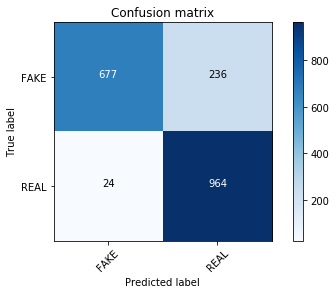

In [20]:
clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [21]:
clf = MultinomialNB()


accuracy:   0.902
Confusion matrix, without normalization


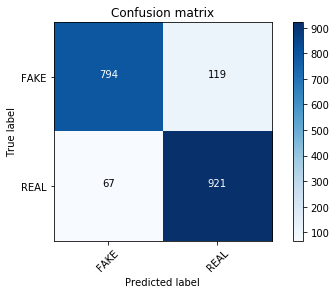

In [22]:
clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Here, with the hyperparameter tuning in place, we have tfidf outperforming!

# Testing Linear Models

There are a lot of great write-ups about how linear models work well with TF-IDF vectorizers 

So we should use SVM?

There has been studies of comparision of Passive Aggressive classifiers to linear SVMs for text classification. We'll test this approach (which has some significant speed benefits and permanent learning disadvantages) with the fake news dataset.

In [23]:
linear_clf = PassiveAggressiveClassifier(n_iter=50)


/home/krishna/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy:   0.940
Confusion matrix, without normalization


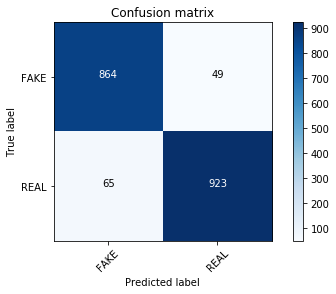

In [24]:
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

Neat! Our model now classifies fake news a tad bit better!

# Introspecting the model

After all the noise in the data, it's not fair to leave at the achieved 93%. We go a bit further and check out the vectors that most affected the labels. Let's inspect the top 30!

In [25]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)


most_informative_feature_for_binary_classification(tfidf_vectorizer, linear_clf, n=30)

FAKE -5.173172807048945 2016
FAKE -4.1048681552627935 october
FAKE -3.8792393743130944 hillary
FAKE -3.0989465068523607 share
FAKE -2.991177677589278 article
FAKE -2.768162669646178 november
FAKE -2.6634558921246985 advertisement
FAKE -2.656212164222786 oct
FAKE -2.546496443324591 print
FAKE -2.5403234224256104 election
FAKE -2.4729077139499207 establishment
FAKE -2.2894199442911902 source
FAKE -2.224479660954297 podesta
FAKE -2.1422430159856 mosul
FAKE -2.0831613982274737 email
FAKE -2.0451836822295277 wikileaks
FAKE -1.9635522886910577 donald
FAKE -1.933988138326874 nov
FAKE -1.8718653520719024 jewish
FAKE -1.8581837408235748 snip
FAKE -1.7920201832533786 photo
FAKE -1.7833530368632031 corporate
FAKE -1.7732681377951391 war
FAKE -1.751437004468643 ayotte
FAKE -1.7151539656029053 reuters
FAKE -1.692576806361282 entire
FAKE -1.6830767175161174 dakota
FAKE -1.6603248861591835 uk
FAKE -1.6484941762040182 26
FAKE -1.648239986444568 watch

REAL 4.690846932438859 said
REAL 2.926580376852401

## HashingVectorizer?

Another vectorizer used sometimes for text classification is a HashingVectorizer. HashingVectorizers require less memory and are faster (because they are sparse and use hashes rather than tokens) but are more difficult to introspect. 

In [26]:
hash_vectorizer = HashingVectorizer(stop_words='english', non_negative=True)
hash_train = hash_vectorizer.fit_transform(X_train)
hash_test = hash_vectorizer.transform(X_test)

/home/krishna/.local/lib/python3.5/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/krishna/.local/lib/python3.5/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/krishna/.local/lib/python3.5/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


In [27]:
clf = MultinomialNB(alpha=.01)


accuracy:   0.908
Confusion matrix, without normalization


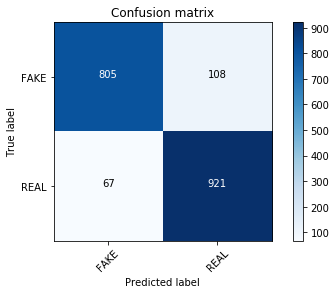

In [28]:
clf.fit(hash_train, y_train)
pred = clf.predict(hash_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

In [29]:
clf = PassiveAggressiveClassifier(n_iter=50)


/home/krishna/.local/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy:   0.925
Confusion matrix, without normalization


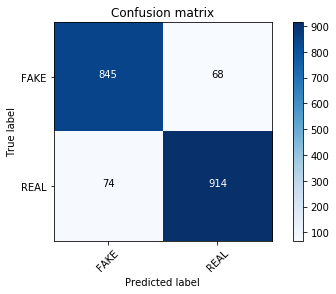

In [30]:
clf.fit(hash_train, y_train)
pred = clf.predict(hash_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

So, That was exciting, wasn't it? This was some good experience testing out some NLP classification models and introspecting how successful they were..